# Tag Aggregation and Visualization

This notebook enables you to aggregate given tags from the Shell dataset. Since I used it for data exploration atm only random tags are aggregated.

*Note: It is assumed that you converted the dataset so all files use the `.parquet` file extension*.

## Loading and validating `.parqet` files

Use the cell below to create a SparkSession. If you want to execute cells indepently you still need to create a new session!

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

spark = (
    SparkSession.builder
    .appName("ShellParquetTagAggregation")
    .getOrCreate()
)


In [43]:
import os

from pathlib import Path

# TODO: must be adjusted to your setup
base_path = "/home/rtdip/Desktop/amos2025ws03-rtdip-timeseries-forecasting/shell_data/raw/Data/2024"

# get all parquet files in the directory
all_files = [str(p) for p in Path(base_path).glob("*.parquet")]


print(f"Found {len(all_files)} parquet candidates")

# validate parquet files
valid_files = []
for f in all_files:
    try:
        df = spark.read.parquet(str(f))
        row_count = df.count()
        print(f"Valid: {os.path.basename(f)} -> {row_count} rows")
        valid_files.append(f)
    except Exception as e:
        print(f"Skipped corrupted file: {os.path.basename(f)} ({e.__class__.__name__})")

print(f"Total valid parquet files: {len(valid_files)}")

Found 435 parquet candidates
Valid: TagMeasurements_float_2024-10-10_06_12_09.072543_DataFrame_45.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_12_09.072543_DataFrame_9.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_02_10.442377_DataFrame_62.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_22_02.458999_DataFrame_4.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_18_48.679350_DataFrame_56.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_12_09.072543_DataFrame_19.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_08_53.060991_DataFrame_16.parquet -> 500000 rows
Valid: TagMeasurements_string_2024-10-10_06_05_44.319928_DataFrame_1.parquet -> 66097 rows
Valid: TagMeasurements_float_2024-10-10_06_05_44.319915_DataFrame_13.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_22_02.458999_DataFrame_2.parquet -> 500000 rows
Valid: TagMeasurements_float_2024-10-10_06_05_44.319915

# Create Tag mapping

In [44]:
# TODO: adjust output path as needed
data_output_dir = "shell_data/aggregated/"

if valid_files:
    print("Combining valid parquet files...")
    df_all = spark.read.option("mergeSchema", "false").parquet(*valid_files)
    print(f"Combined dataset: {df_all.count()} rows, {len(df_all.columns)} columns")

   
    df_with_source = df_all.withColumn("FilePath", input_file_name())

    # tag to file mapping
    df_tag_index = (
        df_with_source.select("TagName", "FilePath")
        .distinct()
        .orderBy("TagName")
    )

    print("Example Tag-File mapping:")
    df_tag_index.show(10, truncate=False)

    # save result
    output_path = "shell_data/tag_file_index.parquet"
    df_tag_index.write.mode("overwrite").parquet(output_path)
    print(f"Tag-File index written to: {output_path}")

else:
    print("No valid parquet files found.")

Combining valid parquet files...
Combined dataset: 214991102 rows, 4 columns
Example Tag-File mapping:


+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TagName                       |FilePath                                                                                                                                                           |
+------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| 13UP1R.:OC2YWCNT7 V7PTDHVAV30|file:///home/rtdip/Desktop/amos2025ws03-rtdip-timeseries-forecasting/shell_data/raw/Data/2024/TagMeasurements_float_2024-10-10_06_15_27.033460_DataFrame_12.parquet|
| 13UP1R.:OC2YWCNT7 V7PTDHVAV30|file:///home/rtdip/Desktop/amos2025ws03-rtdip-timeseries-forecasting/shell_data/raw/Data/2024/TagMeasurements_float_2024-10-10_06_15_27.033460_DataFrame_3.parquet |
| 13UP1R.:OC2YW

Tag-File index written to: shell_data/tag_file_index.parquet


# Aggregate Data for given Tags

In [45]:
tag_index = spark.read.parquet(output_path)

# select #tags to aggregate for visualization
num_tags = 5

tags = [row["TagName"] for row in tag_index.select("TagName").distinct().limit(num_tags).collect()]
print(f"Selected {len(tags)} tags:")
for t in tags:
    print(" ", t)

# aggregate data for each tag
for tag in tags:
    print(f"\nProcessing tag: {tag}")

    # get files for tag
    files = [row["FilePath"] for row in tag_index.filter(tag_index.TagName == tag).collect()]
    print(f"  Found {len(files)} files for tag")

    df_tag = (
        spark.read.option("mergeSchema", "false")
        .parquet(*files)
        .filter(f"TagName = '{tag}'")
        .select("EventTime", "Value", "Status")
    )

    # sort by EventTime!
    df_tag = df_tag.orderBy("EventTime")

    # output and save
    count = df_tag.count()
    print(f"  Aggregated {count} rows for {tag}")

    out_name = tag.strip().replace(" ", "_").replace(":", "_").replace(".", "_")
    out_path = f"{data_output_dir}/{out_name}.parquet"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    df_tag.write.mode("overwrite").parquet(out_path)

    print(f"  Saved aggregated dataset to {out_path}")

Selected 5 tags:
  NPT1M814T1.:20:00V4RTO80
  O3L04P_ME:E-TOTLRVNP4.
  OCN340TE2MYS.1:AIH
  PR:SFIVnV22VL.GCANP_D4-P_1BO_GU
  RNV.X4S0:051PX3

Processing tag: NPT1M814T1.:20:00V4RTO80
  Found 17 files for tag
  Aggregated 119686 rows for NPT1M814T1.:20:00V4RTO80
  Saved aggregated dataset to shell_data/aggregated//NPT1M814T1__20_00V4RTO80.parquet

Processing tag: O3L04P_ME:E-TOTLRVNP4.
  Found 1 files for tag
  Aggregated 38 rows for O3L04P_ME:E-TOTLRVNP4.
  Saved aggregated dataset to shell_data/aggregated//O3L04P_ME_E-TOTLRVNP4_.parquet

Processing tag: OCN340TE2MYS.1:AIH
  Found 31 files for tag
  Aggregated 20018 rows for OCN340TE2MYS.1:AIH
  Saved aggregated dataset to shell_data/aggregated//OCN340TE2MYS_1_AIH.parquet

Processing tag: PR:SFIVnV22VL.GCANP_D4-P_1BO_GU
  Found 1 files for tag
  Aggregated 4 rows for PR:SFIVnV22VL.GCANP_D4-P_1BO_GU
  Saved aggregated dataset to shell_data/aggregated//PR_SFIVnV22VL_GCANP_D4-P_1BO_GU.parquet

Processing tag: RNV.X4S0:051PX3
  Found 28 f

# Visualization

In case you just want to visualize already aggregated tags use the code cell below to start a new spark session...

Found 6 aggregated Parquet files for visualization.
Processing: shell_data/aggregated/OCN340TE2MYS_1_AIH.parquet


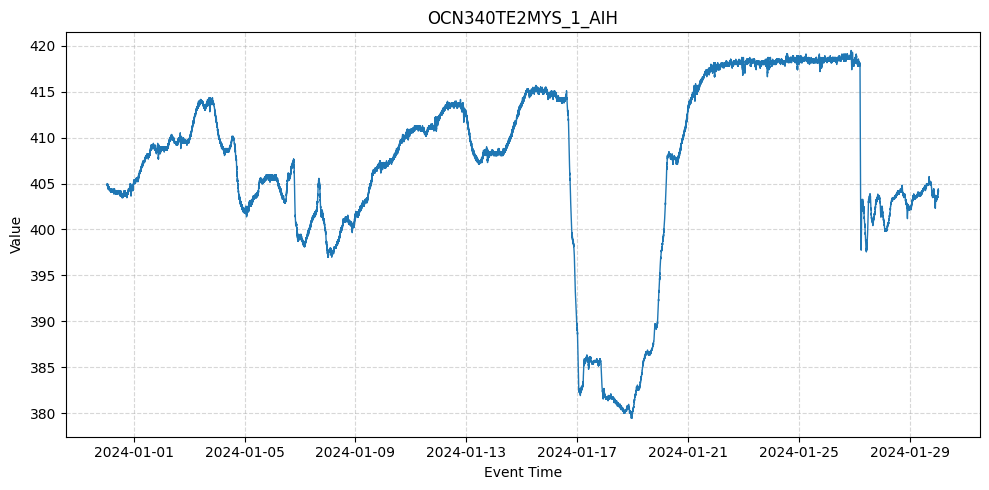

Processing: shell_data/aggregated/RNV_X4S0_051PX3.parquet


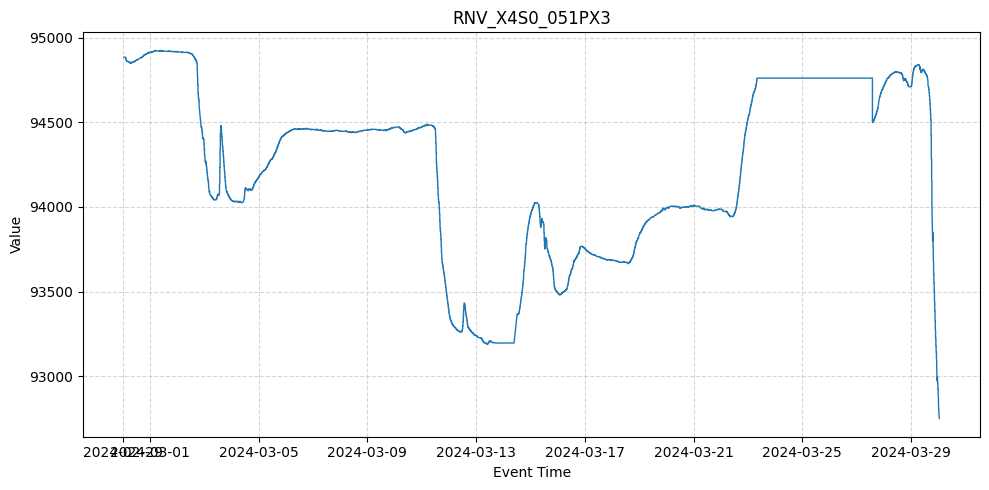

Processing: shell_data/aggregated/PR_SFIVnV22VL_GCANP_D4-P_1BO_GU.parquet


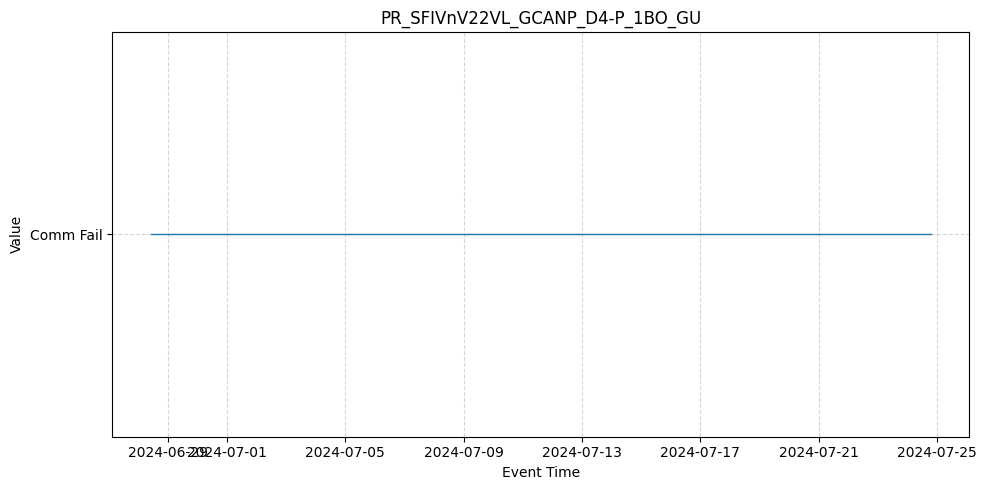

Processing: shell_data/aggregated/MP0T_L22OP6RTGML0-O1FPOUFON_0.parquet


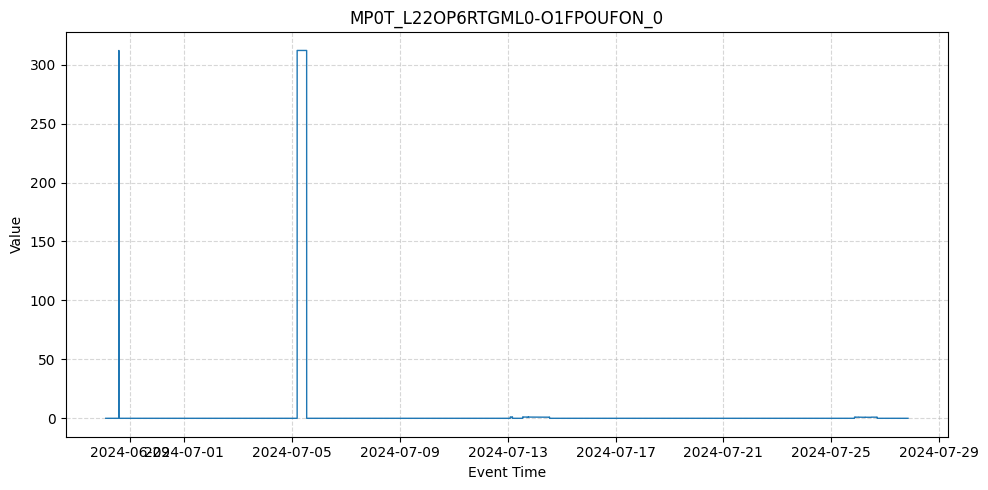

Processing: shell_data/aggregated/NPT1M814T1__20_00V4RTO80.parquet


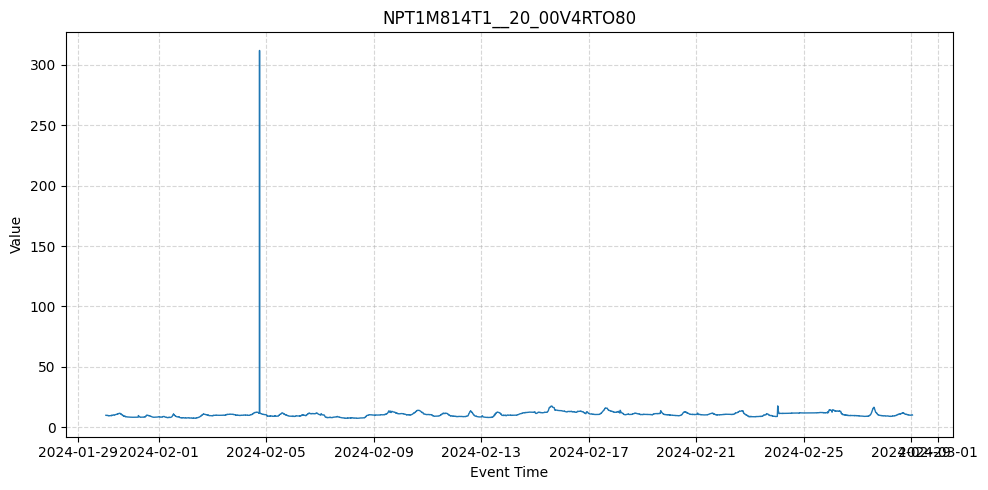

Processing: shell_data/aggregated/O3L04P_ME_E-TOTLRVNP4_.parquet


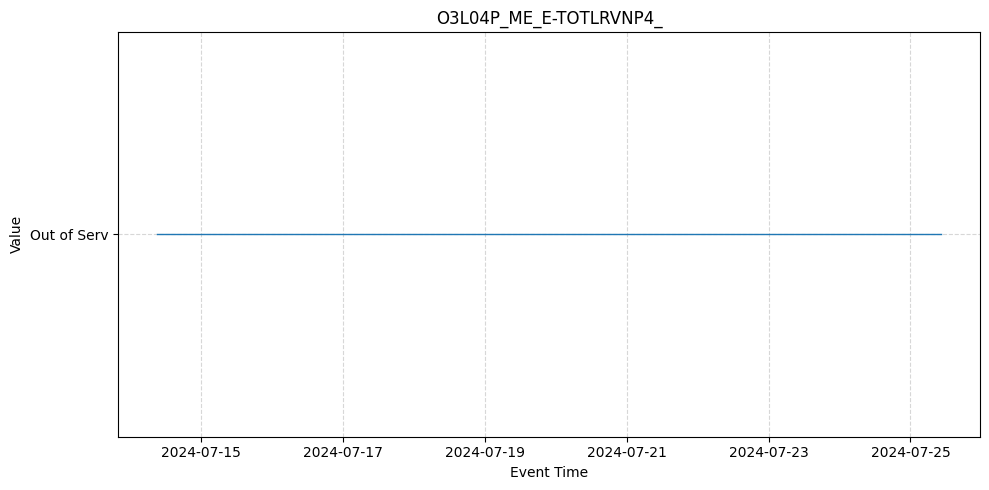

In [46]:
import matplotlib.pyplot as plt
import pandas as pd


agg_files = [
    os.path.join(data_output_dir, d)
    for d in os.listdir(data_output_dir)
    if os.path.isdir(os.path.join(data_output_dir, d)) and d.endswith(".parquet")
]

print(f"Found {len(agg_files)} aggregated Parquet files for visualization.")

for f in agg_files:
    try:
        print(f"Processing: {f}")

        # convert to pandas for matplotlib
        df_spark = spark.read.parquet(f)
        df = df_spark.toPandas()

        # convert and sort time column (it should already be sorted, but just in case...)
        if "EventTime" in df.columns:
            df["EventTime"] = pd.to_datetime(df["EventTime"])
            df = df.sort_values("EventTime")

        # create plot
        plt.figure(figsize=(10, 5))
        plt.plot(df["EventTime"], df["Value"], linewidth=1.0)
        plt.xlabel("Event Time")
        plt.ylabel("Value")
        plt.title(os.path.basename(f).replace(".parquet", ""))
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()

        plt.show()

        plt.close()

    except Exception as e:
        print(f"Skipping {f}: {type(e).__name__} - {e}")

spark.stop()